# Image Captioning
### W266 Final Project (Summer 2019)
### Kenneth Chen 
kl682@berkeley 



## Introduction 
There has been a significant progress in object detection and image recognition by convoluted neural network (CNN). CNN revolutionizes the way images are detected in each hidden layers in the neural networks. Recently there have been a number of attempts at translating the image into text known as machine translation. Given the image, the model predicts the caption describing the content of the image, eg, “a kid throwing a frisbee in an open field.” Therefore the junction between such a computer vision (CV) and natural language processing (NLP) creates a challenging testbed for multiple objects segmentation within an image and realistic interpretation of those objects in the image. This project tries to improve the accuracy of the text generated based on the image. 

### Keywords
NLP, CNN, RNN, encoder, decoder, skip-gram

![Flowchart](img/w266_vgg16_decoder.png)

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from cache import cache

# We need to import several things from Keras.
# from tf.keras.models import Model  # This does not work!
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, Dropout
from tensorflow.python.keras.applications import VGG16, VGG19
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

## Load Data

Download COCO dataset from 
http://cocodataset.org/#download

The directory should look like this:
```
-- w266_final_project.ipynb
-- data
    |--coco
        |--train2017
            |-- 000000000009.jpg, ...
        |--val2017
            |-- 000000000139.jpg, ...
        |--annotations
            |-- captions_train2017.json, ...
        |--transfer_values_train.pkl
        |--transfer_values_val.pkl
        |--records_train.pkl
        |--records_val.pkl
-- coco.py
-- cache.py
```


### filenames_train 
```
('000000000009.jpg',
 '000000000025.jpg',
 '000000000030.jpg',
 '000000000034.jpg',
 '000000000036.jpg',
 ...)
```

### captions_train 
```
(['Closeup of bins of food that include broccoli and bread.',
  'A meal is presented in brightly colored plastic trays.',
  'there are containers filled with different kinds of foods',
  'Colorful dishes holding meat, vegetables, fruit, and bread.',
  'A bunch of trays that have different food.'],
 ['A giraffe eating food from the top of the tree.',
  'A giraffe standing up nearby a tree ',
  'A giraffe mother with its baby in the forest.',
  'Two giraffes standing in a tree filled area.',
  'A giraffe standing next to a forest filled with trees.'],
  ...)
```


## Extracting Flickr30k zipped files

In [2]:
# unzipping flickr images and captions files
# No need to run after extracting, so coded with three quotes
"""
import tarfile
files = tarfile.open("flickr30k-images.tar")
files.extractall('./data/flickr/')

files = zf.ZipFile("Flickr30k_text.zip", 'r')
files.extractall('./data/flickr/')
"""

'\nimport tarfile\nfiles = tarfile.open("flickr30k-images.tar")\nfiles.extractall(\'./data/flickr/\')\n\nfiles = zf.ZipFile("Flickr30k_text.zip", \'r\')\nfiles.extractall(\'./data/flickr/\')\n'

### Loading Flickr30k Dataset

In [3]:
# Flickr captions engineering to the same format as coco
# The dataset does not have a particular image "2258277193_586949ec62.jpg.1" although it does have its caption,
# so we need to remove the image and its captions as well.
import flickr30k

token = 'data/flickr/Flickr30k_text/Flickr30k.token.txt'
captions = open(token, 'r').read().strip().split('\n')

caption_l = []
cap_5 = []
filenames = []
for i in range(len(captions)):
    cap = captions[i].split('\t')[1]
    cap_5.append(cap)
    if len(cap_5)%5 == 0:
        idx = captions[i].split('\t')[0].split('#')[0]
        filenames.append(idx)
        caption_l.append(cap_5)
        cap_5 = []
captions_flickr30k = tuple(caption_l)
filenames_flickr30k = tuple(filenames)

captions_flickr30k_train = captions_flickr30k[:20000]
filenames_flickr30k_train = filenames_flickr30k[:20000]


captions_flickr30k_valtest = captions_flickr30k[20000:]
filenames_flickr30k_valtest = filenames_flickr30k[20000:]

captions_flickr30k_val = captions_flickr30k[20000:25000]
filenames_flickr30k_val = filenames_flickr30k[20000:25000]

captions_flickr30k_test = captions_flickr30k[25000:]
filenames_flickr30k_test = filenames_flickr30k[25000:]


### Loading and Showing Images

Images are loaded based on the index from the train or validation dataset. Each image has 5 captions. 

In [4]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """
    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)
        
    # Convert image to numpy array and scale the pixel between 0 and 1.
    img = np.array(img)
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

def show_image(idx, train):

    if train:
        # Use an image from the training-set.
        dir = flickr30k.train_dir
        filename = filenames_flickr30k_train[idx]
        captions = captions_flickr30k_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_flickr30k_val[idx]
        captions = captions_flickr30k_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

### Example Image

Show an example image and captions from the training-set.

Someone in a blue shirt and hat is standing on stair and leaning against a window .
A man in a blue shirt is standing on a ladder cleaning a window .
A man on a ladder cleans the window of a tall building .
man in blue shirt and jeans on ladder cleaning windows
a man on a ladder cleans a window


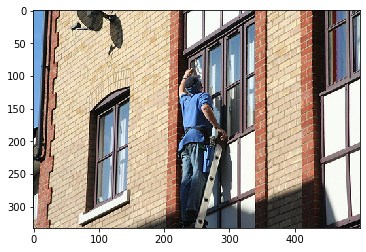

In [5]:
show_image(idx=3, train=True)

## Pre-Trained Image Model (VGG16)

The following creates an instance of the VGG16 model using the Keras API. The VGG16 model (Oxford Visual Geometry Group) was developed based on ImageNet. There are a number of models developed to classify ImageNet: VGG16, VGG19, InceptionV3, Xception, ResNet and so on. The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for the image classification.

- `include_top=True`, the whole VGG16 model is downloaded which is about 528 MB.  
- `include_top=False`, only the convolutional part of the VGG16 model is downloaded which is just 57 MB. The two Dense output layers as well as the classification output layer will be removed. 

In [6]:
# https://keras.io/applications/#vgg16
# keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', \
# input_tensor=None, input_shape=None, pooling=None, classes=1000)

model_vgg16 = VGG16(include_top=True, weights='imagenet')

You can check a list of all the layers in the VGG16 model by `model_vgg16.summary()`. 

In [7]:
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

From the summary, you can see the first layer input is in `(None, 224, 224, 3)` dimension. `None` is for undefined batch size. So we will need to conform to this input dimensionality in processing our COCO images. 

### Model (1) : A modified model transferred from VGG16

We modify the VGG16 model by removing the final classification layer or predictions layer. 

In [8]:
# getting the intermediate layer from VGG16
transfer_layer = model_vgg16.get_layer('fc2')

# A model expects the input size as follows
img_size = K.int_shape(model_vgg16.input)[1:3]
print("Input to a new model    : ", img_size)

# A new model will output a vector of `4096` in size
transfer_values_size = K.int_shape(transfer_layer.output)[1]
print("Output from a new model : ", transfer_values_size)

# Building the model 
model_transferred = Model(inputs=model_vgg16.input, outputs=transfer_layer.output)

Input to a new model    :  (224, 224)
Output from a new model :  4096


### Process All Images

This will process all COCO train images `118,287` in VGG16 architecture and save the output `4096` from each image and store them in pickle format so that we can retrieve the transfer values in next run. We will not train the entire VGG16 weights, which will take a long time to train. Instead, we will use the weights trained on ImageNet and save the output `4096` values as our COCO images transfer values from VGG16 model. 

In [9]:
def print_progress(count, max_count):

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(count/max_count)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

This is the function for processing the given files using the VGG16-model and returning their transfer-values.

In [10]:
# Any images using the VGG16 model, 
# using `predict()` function to get the image vector out of VGG16 CNN

def process_images(data_dir, filenames, batch_size=32):
    
    # Number of images to process.
    total_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)                  # (32,) + (224, 224) + (3,) = (32, 224, 224, 3)
    image_batch = np.zeros(shape=shape, dtype=np.float16)    # (32, 224, 224, 3) input format for VGG16

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (total_images, transfer_values_size)             # (118287, 4096)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < total_images:
        print_progress(count=start_index, max_count=total_images)

        # End-index for this batch.
        end_index = start_index + batch_size                 # 0 + 32 = 32 for 1st batch

        # Ensure end-index is within bounds.
        if end_index > total_images:
            end_index = total_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image. This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = model_transferred.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

Helper-function for processing all images in the training-set. This saves the transfer-values in a cache-file for fast reloading.

In [11]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_flickr30k_train)))

    # Path for the cache-file.
    cache_path = os.path.join(flickr30k.data_dir, "transfer_values_flickr30k_train.pkl")
    
    # def process_images has 3 arguments: data_dir, filenames, batch_size
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=flickr30k.train_dir,
                            filenames=filenames_flickr30k_train)

    return transfer_values

def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_flickr30k_val)))

    # Path for the cache-file.
    cache_path = os.path.join(flickr30k.data_dir, "transfer_values_flickr30k_val.pkl")

    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=flickr30k.train_dir,
                            filenames=filenames_flickr30k_val)

    return transfer_values

def process_images_test():
    print("Processing {0} images in test-set ...".format(len(filenames_flickr30k_test)))

    # Path for the cache-file.
    cache_path = os.path.join(flickr30k.data_dir, "transfer_values_flickr30k_test.pkl")
    
    # def process_images has 3 arguments: data_dir, filenames, batch_size
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=flickr30k.train_dir,
                            filenames=filenames_flickr30k_test)

    return transfer_values

def process_images_valtest():
    print("Processing {0} images in validation_test-set ...".format(len(filenames_flickr30k_valtest)))

    # Path for the cache-file.
    cache_path = os.path.join(flickr30k.data_dir, "transfer_values_flickr30k_valtest.pkl")

    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=flickr30k.train_dir,
                            filenames=filenames_flickr30k_valtest)

    return transfer_values

Process all images in the training-set and save the transfer-values to a cache-file. This took about 30 minutes to process on a GTX 1070 GPU.

In [12]:
%%time
transfer_values_flickr30k_train = process_images_train()
print("dtype:", transfer_values_flickr30k_train.dtype)
print("shape:", transfer_values_flickr30k_train.shape)

print("-"*60)
transfer_values_flickr30k_val = process_images_val()
print("dtype:", transfer_values_flickr30k_val.dtype)
print("shape:", transfer_values_flickr30k_val.shape)

print("-"*60)
transfer_values_flickr30k_test = process_images_test()
print("dtype:", transfer_values_flickr30k_test.dtype)
print("shape:", transfer_values_flickr30k_test.shape)

print("-"*60)
transfer_values_flickr30k_valtest = process_images_valtest()
print("dtype:", transfer_values_flickr30k_valtest.dtype)
print("shape:", transfer_values_flickr30k_valtest.shape)
print("-"*60)

Processing 20000 images in training-set ...
- Data loaded from cache-file: data/flickr/transfer_values_flickr30k_train.pkl
dtype: float16
shape: (20000, 4096)
------------------------------------------------------------
Processing 5000 images in validation-set ...
- Data loaded from cache-file: data/flickr/transfer_values_flickr30k_val.pkl
dtype: float16
shape: (5000, 4096)
------------------------------------------------------------
Processing 6783 images in test-set ...
- Data loaded from cache-file: data/flickr/transfer_values_flickr30k_test.pkl
dtype: float16
shape: (6783, 4096)
------------------------------------------------------------
Processing 11783 images in validation_test-set ...
- Data loaded from cache-file: data/flickr/transfer_values_flickr30k_valtest.pkl
dtype: float16
shape: (11783, 4096)
------------------------------------------------------------
CPU times: user 72 ms, sys: 380 ms, total: 452 ms
Wall time: 447 ms


## Tokenizer

We will need to tokenize the caption because neural network cannot work on literal string text. In order to create a corpus for all the captions, we first tokenize each word in each caption and create a dictionary. Since we'd be using the skip-gram model, which predict next words (context words) based on the current word (target), opposite of CBOW (Continous Bag of Words), we need to pad the start and end characters in each caption. 

There are two models in text prediction. 

- CBOW (Continuous Bag of Words) 
- Skip-gram 


<p align="center">
<img src="img/cbow_skipgram.png" width="800"></p>

In [13]:
mark_start = 'ssss '
mark_end = ' eeee'

def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

captions_train_marked_flickr30k = mark_captions(captions_flickr30k_train)
captions_train_marked_flickr30k[3]

['ssss Someone in a blue shirt and hat is standing on stair and leaning against a window . eeee',
 'ssss A man in a blue shirt is standing on a ladder cleaning a window . eeee',
 'ssss A man on a ladder cleans the window of a tall building . eeee',
 'ssss man in blue shirt and jeans on ladder cleaning windows eeee',
 'ssss a man on a ladder cleans a window eeee']

In [14]:
# Since the tokenizer cannot take list of list, we flatten the captions list into a single list.

def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

captions_train_flat_flickr30k = flatten(captions_train_marked_flickr30k)
captions_train_flat_flickr30k[:6]

['ssss Two young guys with shaggy hair look at their hands while hanging out in the yard . eeee',
 'ssss Two young , White males are outside near many bushes . eeee',
 'ssss Two men in green shirts are standing in a yard . eeee',
 'ssss A man in a blue shirt standing in a garden . eeee',
 'ssss Two friends enjoy time spent together . eeee',
 'ssss Several men in hard hats are operating a giant pulley system . eeee']

### Tokenization

We need a few more functions than provided by Keras' Tokenizer-class so we wrap it.

In [15]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(), self.word_index.keys()))

    def token_to_word(self, token):

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):

        # Create a list of the individual words.
        words = [self.index_to_word[token] for token in tokens if token != 0]
        
        # Concatenate the words to a single string
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list) for captions_list in captions_listlist]
        
        return tokens

Now create a tokenizer using all the captions in the training-data. Note that we use the flattened list of captions to create the tokenizer because it cannot take a list-of-lists.

In [16]:
%%time
num_words = 10000
tokenizer = TokenizerWrap(texts=captions_train_flat_flickr30k,
                          num_words=num_words)

CPU times: user 2.3 s, sys: 12 ms, total: 2.31 s
Wall time: 2.3 s


Get the integer-token for the start-marker (the word "ssss"). We will need this when we generate captions.

In [17]:
token_start = tokenizer.word_index[mark_start.strip()]
print("token_start: ", token_start)
token_end = tokenizer.word_index[mark_end.strip()]
print("token_end  : ", token_end)

token_start:  2
token_end  :  3


Convert all the captions from the training-set to sequences of integer-tokens. We get a list-of-list as a result.

In [18]:
%%time
tokens_train_flickr30k = tokenizer.captions_to_tokens(captions_train_marked_flickr30k)

CPU times: user 1.97 s, sys: 24 ms, total: 2 s
Wall time: 2 s


In [19]:
# testing tokens_to_string 
tokenizer.tokens_to_string([1, 2, 3, 4, 5, 6])

'a ssss eeee in the on'

In [20]:
tokenizer.captions_to_tokens([['ssss a black car drives by a store . eeee']])

[[[2, 1, 23, 136, 966, 47, 1, 241, 3]]]

Example of the integer-tokens for the captions of the first image in the training-set:

In [21]:
tokens_train_flickr30k[0]

[[2, 12, 22, 339, 11, 1864, 95, 190, 17, 65, 162, 25, 331, 74, 4, 5, 410, 3],
 [2, 12, 22, 21, 693, 14, 60, 81, 196, 1276, 3],
 [2, 12, 32, 4, 50, 232, 14, 33, 4, 1, 410, 3],
 [2, 1, 8, 4, 1, 26, 20, 33, 4, 1, 733, 3],
 [2, 12, 463, 825, 596, 9696, 131, 3]]

These are the corresponding text-captions:

In [22]:
captions_train_marked_flickr30k[0]

['ssss Two young guys with shaggy hair look at their hands while hanging out in the yard . eeee',
 'ssss Two young , White males are outside near many bushes . eeee',
 'ssss Two men in green shirts are standing in a yard . eeee',
 'ssss A man in a blue shirt standing in a garden . eeee',
 'ssss Two friends enjoy time spent together . eeee']

## Data Batch Generator

Each image has 5 captions. However to train each image with its respective 5 labels will take a longer time and repetition. Instead we will randomly select 1 caption out of 5 available ones and train with transfer value (image vector `4096` generated from VGG16 model). 

Note that it selects the data completely randomly for each batch, corresponding to sampling of the training-set with replacement. This means it is possible to sample the same data multiple times within a single epoch - and it is also possible that some data is not sampled at all within an epoch. However, all the data should be unique within a single batch.

In [23]:
num_images_train = len(filenames_flickr30k_train)

def get_random_caption_tokens(idx):
    
    result = []

    for i in idx:
        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train_flickr30k[i]))
        tokens = tokens_train_flickr30k[i][j]
        result.append(tokens)

    return result


def batch_generator(batch_size):

    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train, size=batch_size)
        
        # Get the pre-computed transfer-values for those images and their caption randomly (only 1 caption out of 5)
        transfer_values = transfer_values_flickr30k_train[idx]
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in selected caption
        num_tokens = [len(t) for t in tokens]
        max_tokens = np.max(num_tokens)             # maximum length of the tokenized_caption within a given batch
        
        # Pad all the other token-sequences with zeros
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        decoder_input_data = tokens_padded[:, 0:-1]      # removing the last token because it can't predict the next word at the end
        decoder_output_data = tokens_padded[:, 1:]       # removing the first token because it is 'ssss ', not predicted from the previous word

        # Dict for the input data
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

### Generating the input, output data for RNN

In [24]:
batch_size = 512         # Set high to maximal usage at GPU. 

generator = batch_generator(batch_size=batch_size)

# generating one batch worth of input and output to check
batch = next(generator)
batch_x = batch[0]       # input will have 512 images vectors
batch_y = batch[1]       # output will have 512 tokenized captions

print("batch_x has {} images".format(len(batch_x['transfer_values_input'])))
print("sample of first image in the batch")
batch_x['transfer_values_input'][0]

batch_x has 512 images
sample of first image in the batch


array([ 0.        ,  0.        ,  1.42675781, ...,  0.        ,
        0.        ,  0.54541016], dtype=float16)

Example of the token-sequence for the first image in the batch. This is the input to the decoder-part of the neural network.

In [25]:
print("This is the tokenized caption input to the decoder model")
print(batch_x['decoder_input'][0])
print("-"*60)
print("This is the tokenized caption output from the decoder model")
print(batch_y['decoder_output'][0])
print("")
print("--> The output is one token shifted to the left because we are predicting the next word based on the current word, skip-gram model)")

This is the tokenized caption input to the decoder model
[   2   35    4  487  283   38 1043    7   42    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
------------------------------------------------------------
This is the tokenized caption output from the decoder model
[  35    4  487  283   38 1043    7   42    3    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]

--> The output is one token shifted to the left because we are predicting the next word based on the current word, skip-gram model)


### Steps Per Epoch

We need to calculate how many batches required for one epoch. Since our batch size is 512, which means there are 512 images or captions will be trained per batch, how many many captions there are in the first place? Since captions are randomly selected, even for the same image, the caption selected in the previous batch might be different from the caption selected in the current batch. So we calculate how many batches required for one epoch. There are `591,753` captions for the entire train dataset. If `512` captions are trained per batch, we'd need `591753/512` for one epoch. 

In [26]:
# total captions = total images * 5 = 20000 * 5 = 100000

num_captions_train_flickr30k = [len(captions) for captions in captions_flickr30k_train]
total_num_captions_train_flickr30k = np.sum(num_captions_train_flickr30k)
print("Total number of captions     : ", total_num_captions_train_flickr30k)

steps_per_epoch = int(total_num_captions_train_flickr30k / batch_size)
print("Steps required for one epoch : ", steps_per_epoch)

Total number of captions     :  100000
Steps required for one epoch :  195


### Model (2) : Create the Recurrent Neural Network (RNN) 

We will now create the Recurrent Neural Network (RNN) that will be trained to map the vectors with transfer-values from the image-recognition model into sequences of integer-tokens that can be converted into text. We have split the network construction into two parts: (1) Creation of all the layers that are not yet connected, and (2) a function that connects all these layers.

The decoder consists of 3 GRU layers whose internal state-sizes are `512`. 

We want to use the transfer-values to initialize the internal states of the GRU units. This informs the GRU units of the contents of the images. The transfer-values are vectors of length 4096 but the size of the internal states of the GRU units are only 512, so we use a fully-connected layer to map the vectors from 4096 to 512 elements.

Note that we use a `tanh` activation function to limit the output of the mapping between -1 and 1, otherwise this does not seem to work.

In [27]:
state_size = 512
embedding_size = 128
dropout_rate = 0.8

# transfer_values_size = 4096
# transfer value from VGG16 to the RNN
transfer_values_input = Input(shape=(transfer_values_size,), name='transfer_values_input')

decoder_transfer_map = Dense(state_size, activation='tanh', name='decoder_transfer_map')

# This is the input for token-sequences to the decoder.
decoder_input = Input(shape=(None, ), name='decoder_input')

# This is the embedding-layer which converts sequences of integer-tokens to sequences of vectors.
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

# 3 GRU layers 
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)
#decoder_gru4 = GRU(state_size, name='decoder_gru4',
#                   return_sequences=True)
#decoder_gru5 = GRU(state_size, name='decoder_gru5',
#                   return_sequences=True)

# final connected layer 
decoder_dense = Dense(num_words, activation='linear', name='decoder_output')

# dropout layer 
dropout = Dropout(rate=dropout_rate, name='dropout_layer')

## Build the Final Model (VGG16 + RNN) 

The decoder (RNN) is built using the functional API of Keras, which allows more flexibility in connecting the layers e.g. to have multiple inputs. This is useful e.g. if you want to connect the image-model directly with the decoder instead of using pre-calculated transfer-values. This function connects all the layers of the decoder to some input of transfer-values.

In [28]:
dropout_rate = 0.8

def connect_decoder(transfer_values):

    # transferred value from VGG16, will be used in GRU initial_state
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer and embedding layer
    net = decoder_input
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    #net = decoder_gru2(net, initial_state=initial_state)
    #net = decoder_gru3(net, initial_state=initial_state)

    #net = dropout(net)
    
    decoder_output = decoder_dense(net)
    
    return decoder_output

Connect and create the model used for training. This takes as input transfer-values and sequences of integer-tokens and outputs sequences of one-hot encoded arrays that can be converted into integer-tokens.

In [29]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

### Loss Function

The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.However, our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 10000 elements so it would be extremely wasteful to convert the entire data-set to one-hot encoded arrays. A better way is to use a so-called `sparse cross-entropy loss-function`, which does the conversion internally from integers to one-hot encoded arrays. Unfortunately, there seems to be a bug in Keras when using this with Recurrent Neural Networks, so the following does not work:

In [30]:
def sparse_cross_entropy(y_true, y_pred):

    # Calculate the loss. This outputs a 2-rank tensor of shape [batch_size, sequence_length]
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

    # reduce the batch loss to a single scalar loss by taking mean
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### Compile the Training Model


There seems to be another bug in Keras so it cannot automatically deduce the correct shape of the decoder's output data. We therefore need to manually create a placeholder variable for the decoder's output. The shape is set to `(None, None)` which means the batch can have an arbitrary number of sequences, which can have an arbitrary number of integer-tokens.

In [31]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

decoder_model.compile(optimizer=RMSprop(lr=1e-3),
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [32]:
# Saving checkpoints for weights
path_checkpoint = 'checkpoint_w266_flickr30k.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

# Saving logs
callback_tensorboard = TensorBoard(log_dir='./logs_w266/',
                                   histogram_freq=0,
                                   write_graph=False)

# Calling back if there's any previously saved checkpoints
callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint

You can reload the last saved checkpoint so you don't have to train the model every time you want to use it.

In [33]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'checkpoint_w266_flickr30k.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


### Train the Model

Now we will train the decoder so it can map transfer-values from the image-model to sequences of integer-tokens for the captions of the images. I train the model in GPU. For 20 epochs, it takes about an hour and half. 

In [34]:
# Make it easier to run "Restart and Run all" command 
# before the actual training step in next cell
print(bump)

NameError: name 'bump' is not defined

In [35]:
%%time
decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=50,
                            callbacks=callbacks)

Epoch 1/50


/jet/var/python/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


194/195 [============================>.] - ETA: 0s - loss: 1.9964
Epoch 00001: saving model to checkpoint_w266_flickr30k.keras
195/195 [==============================] - 36s 187ms/step - loss: 1.9904
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 1.4435
Epoch 00002: saving model to checkpoint_w266_flickr30k.keras
195/195 [==============================] - 35s 178ms/step - loss: 1.4440
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 1.3176
Epoch 00003: saving model to checkpoint_w266_flickr30k.keras
195/195 [==============================] - 34s 175ms/step - loss: 1.3175
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 1.2009
Epoch 00004: saving model to checkpoint_w266_flickr30k.keras
195/195 [==============================] - 35s 182ms/step - loss: 1.1994
Epoch 5/50
194/195 [============================>.] - ETA: 0s - loss: 1.1506
Epoch 00005: saving model to checkpoint_w266_flickr30k.keras
195/195 [====================

195/195 [==============================] - 34s 177ms/step - loss: 0.7892
Epoch 40/50
194/195 [============================>.] - ETA: 0s - loss: 0.7773
Epoch 00040: saving model to checkpoint_w266_flickr30k.keras
195/195 [==============================] - 35s 177ms/step - loss: 0.7771
Epoch 41/50
194/195 [============================>.] - ETA: 0s - loss: 0.7751
Epoch 00041: saving model to checkpoint_w266_flickr30k.keras
195/195 [==============================] - 34s 177ms/step - loss: 0.7748
Epoch 42/50
194/195 [============================>.] - ETA: 0s - loss: 0.7692
Epoch 00042: saving model to checkpoint_w266_flickr30k.keras
195/195 [==============================] - 34s 177ms/step - loss: 0.7699
Epoch 43/50
194/195 [============================>.] - ETA: 0s - loss: 0.7614
Epoch 00043: saving model to checkpoint_w266_flickr30k.keras
195/195 [==============================] - 35s 178ms/step - loss: 0.7609
Epoch 44/50
194/195 [============================>.] - ETA: 0s - loss: 0.7566
E

## Generate Captions by skip-gram

This function loads an image and generates a caption using the model we have trained. The model will predict the next word based on the current word. Once we receive the predicted word, we will use the predicted word as our base word and the model will predict the next word. This prediction will continue until the model reaches either (1) the end of the word indicated by `'eeee'` or (2) a user-defined length of the captions. 

In [36]:
def generate_caption(image_path, max_tokens=30):

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    image_batch = np.expand_dims(image, axis=0)

    # Process the image 
    transfer_values = model_transferred.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text and token count to zero. 
    count_tokens = 0
    output_text = ''

    while token_int != token_end and count_tokens < max_tokens:

        decoder_input_data[0, count_tokens] = token_int          # assign the first word 'ssss ' in the preallocated position

        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # convert to onehot (actually not one hot exactly), take the index of the largest value by np.argmax, then convert to text by tokenizer
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)                       # update from token 2 ('ssss ') to a new token
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # strip the end word ' eeee' from the caption
    caption = ' '.join(output_text.split()[:-1])
    # Print the predicted caption.
    print("Predicted caption:")
    print(caption)
    print()

## Examples on Flickr30k train, validation and test images

In [37]:
def generate_caption_flickr30k(idx, train=False):
    
    if train:
        # Use image and captions from the training-set.
        data_dir = flickr30k.train_dir
        filename = filenames_flickr30k_train[idx]
        captions = captions_flickr30k_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = flickr30k.train_dir
        filename = filenames_flickr30k_valtest[idx]
        captions = captions_flickr30k_valtest[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    generate_caption(image_path=path)

    # Print the true captions from the data-set.
    print("True captions:")
    for caption in captions:
        print(caption)

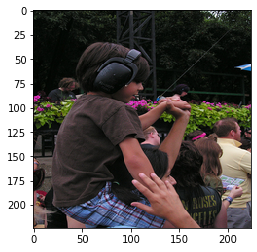

Predicted caption:
a man in a black shirt and jeans is playing a guitar

True captions:
Boy in brown shirt with headphones on sits on woman 's shoulders in a crowd .
A kid wearing headphones sits on his mom 's shoulders while in a crowd .
A boy with headphones on sitting on top of a woman 's shoulders .
A child with headphones riding on his mother 's shoulders .
A boy wearing headphones sits on a woman 's shoulders .


In [38]:
generate_caption_flickr30k(idx=100, train=True)

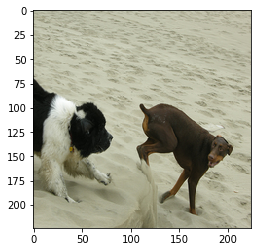

Predicted caption:
a dog is running on the beach

True captions:
A white and black dog and a brown dog in sandy terrain .
Two large dogs chasing each other at the beach .
The two large dogs are running through sand .
One dog is chasing another one on the beach .
A woolly dog chases a Doberman on a beach .


In [39]:
generate_caption_flickr30k(idx=200, train=True)

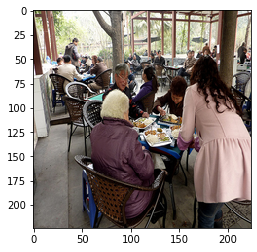

Predicted caption:
a man in a hat is sitting on a bench with a city

True captions:
Even though it 's rather cool for outdoor dining , many people are enjoying the cafeteria-style food .
Several parties of people are seated in a dining room , eating food .
A woman in pink serves food two Asian people in an elderly home .
A group of people are having lunch in a crowded cafe .
Group having a meal in an outdoor setting .


In [40]:
generate_caption_flickr30k(idx=100, train=False)

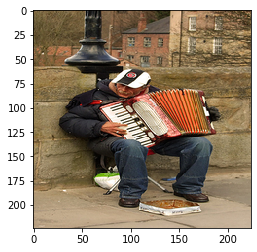

Predicted caption:
a man in a black shirt and jeans is sitting on a bench with a bag of produce on his hands

True captions:
An older man dressed in jeans and a puffy dark jacket plays the accordion , seated in front of a stone wall .
Man sitting outside on sidewalk playing music while taking donations .
A middle-aged man is sitting down and playing the accordion .
Pan handler playing the accordion on the sidewalk .
A street musician is playing the accordion .


In [41]:
generate_caption_flickr30k(idx=200, train=False)

## Examples (on COCO validation images)

Helper-function for loading an image from the COCO data-set and printing the true captions as well as the predicted caption.

In [42]:
import coco
_, filenames_train, captions_train = coco.load_records(train=True)
_, filenames_val, captions_val = coco.load_records(train=False)

def generate_caption_coco(idx, train=False):
    
    if train:
        # Use image and captions from the training-set.
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    generate_caption(image_path=path)

    # Print the true captions from the data-set.
    print("True captions:")
    for caption in captions:
        print(caption)

- Data loaded from cache-file: data/coco/records_train.pkl
- Data loaded from cache-file: data/coco/records_val.pkl


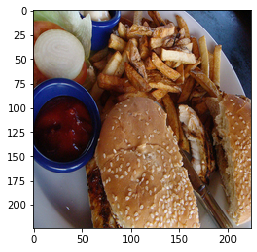

Predicted caption:
a man in a black shirt and black shorts is playing a guitar

True captions:
A plate of food which includes onions, tomato, lettuce, sauce, fries, and a sandwich.
A sandwich, french fries, bowl of ketchup, onion slice, lettuce slice, tomato slice, and knife sit on the white plate.
Partially eaten hamburger on a plate with fries and condiments. 
A grilled chicken sandwich sits beside french fries made with real potatoes. 
A sandwich on a sesame seed bun next to a pile of french fries and a cup of ketchup.


In [43]:
generate_caption_coco(idx=100, train=False)

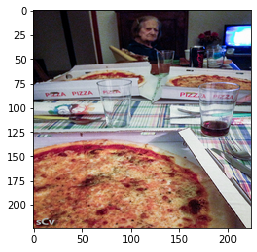

Predicted caption:
a man in a blue shirt and blue jeans is laying on the ground next to a white and blue boat

True captions:
A woman sitting at a table topped with pizza.
A close-up of a table with three boxes of pizza.
An elderly woman seated at a table holding three pizzas.
A grandmother looks at her family's pizza dinner
Pizza and empty glasses on the dinner table.


In [44]:
generate_caption_coco(idx=120, train=False)

Here is a picture from the validation-set which was not used during training of the model. Sometimes the model can produce good captions for images it hasn't seen during training and sometimes it can't. Can you make a better model?

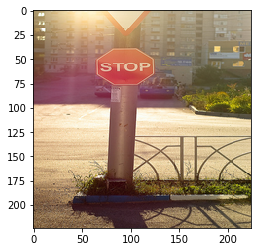

Predicted caption:
a man in a black shirt and jeans is standing in front of a white wall

True captions:
A stop sigh on a post with two buses in the background.
an image of a stop sign and yield sign
A stop sign on post with a building in the background.
A stop sign sitting on top of a metal column.
a street sign with buildings in the background


In [45]:
generate_caption_coco(idx=150, train=False)

## Examples on non-Flickr30k, COCO images

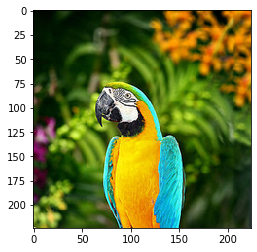

Predicted caption:
a black dog is carrying a ball in its mouth



In [46]:
generate_caption("images/parrot_cropped1.jpg")

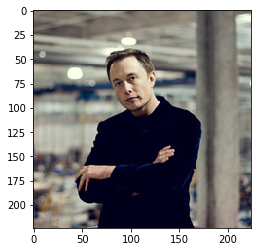

Predicted caption:
a man in a black shirt and black hat is playing with a yo yo



In [47]:
generate_caption("images/elon_musk.jpg")

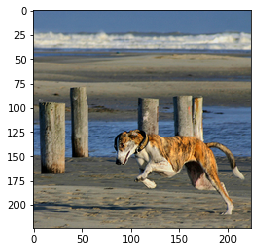

Predicted caption:
a dog is running along a beach



In [48]:
generate_caption("images/flickr_dog_running.jpg")

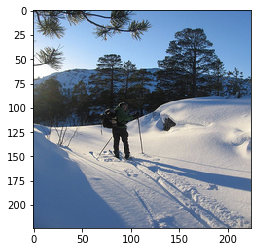

Predicted caption:
a man is skiing down a hill



In [49]:
generate_caption("images/snow.jpg")

## Evaluation by BLEU (BiLingual Evaluation Understudy) score

In [50]:
def generate_caption_only_flickr30k(image_path, max_tokens=30):

    image = load_image(image_path, size=img_size)
    image_batch = np.expand_dims(image, axis=0)
    transfer_values = model_transferred.predict(image_batch)
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = token_start
    count_tokens = 0
    output_text = ''

    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int          
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        decoder_output = decoder_model.predict(x_data)
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)                       
        sampled_word = tokenizer.token_to_word(token_int)
        output_text += " " + sampled_word
        count_tokens += 1

    #plt.imshow(image)
    #plt.show()

    return output_text.split()[:-1]   

captions_train_token_flickr30k = []
for captions in captions_flickr30k_train:
    cap_t = []
    for i in range(len(captions)):
        cap_t.append(captions[i].split())
    captions_train_token_flickr30k.append(cap_t)
    
captions_valtest_token_flickr30k = []
for captions in captions_flickr30k_valtest:
    cap_v = []
    for i in range(len(captions)):
        cap_v.append(captions[i].split())
    captions_valtest_token_flickr30k.append(cap_v)
    

def generate_caption_valtest(idx, train=False):
    
    if train:
        # Use image and captions from the training-set.
        data_dir = flickr30k.train_dir
        filename = filenames_flickr30k_train[idx]
        captions = captions_train_token_flickr30k[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = flickr30k.train_dir
        filename = filenames_flickr30k_valtest[idx]
        captions = captions_valtest_token_flickr30k[idx]

    path = os.path.join(data_dir, filename)

    predicted_caption = generate_caption_only_flickr30k(image_path=path)
    
    return (captions, predicted_caption)

In [51]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
chencherry = SmoothingFunction()
reference, candidate = generate_caption_valtest(150, train=False)
score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method4)
print(score)

0.2078060434846712


In [53]:
# Rouge score determination
# taking the average of 5 captions precision and recall
import rouge

# apply_avg=True (default)
evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                        max_n=4,
                       limit_length=True,
                       length_limit=100,
                       length_limit_type='words',
                       alpha=0.5, # Default F1_score
                       weight_factor=1.2,
                       stemming=True)

## BLEU and ROUGE score for Flickr30k valtest dataset

In [54]:
# For validation dataset
# from tqdm import tqdm

total_val = int(len(filenames_flickr30k_valtest))
print("Total number of images in Flickr30k valtest dataset : ", total_val)

chencherry = SmoothingFunction()
score1, score2, score3, score4 = 0, 0, 0, 0
score1c, score2c, score3c, score4c = 0, 0, 0, 0

# initializing precision, p and recall, r 
rouge_1p, rouge_2p, rouge_3p, rouge_4p, rouge_lp, rouge_wp = 0, 0, 0, 0, 0, 0
rouge_1r, rouge_2r, rouge_3r, rouge_4r, rouge_lr, rouge_wr = 0, 0, 0, 0, 0, 0

count = 0
for i in range(total_val):
    # For BLEU
    refs, predicted = generate_caption_valtest(i, train=False)
    score1_temp = sentence_bleu(refs, predicted, weights=(1, 0, 0, 0), smoothing_function=chencherry.method4)
    score2_temp = sentence_bleu(refs, predicted, weights=(0, 1, 0, 0), smoothing_function=chencherry.method4)
    score3_temp = sentence_bleu(refs, predicted, weights=(0, 0, 1, 0), smoothing_function=chencherry.method4)
    score4_temp = sentence_bleu(refs, predicted, weights=(0, 0, 0, 1), smoothing_function=chencherry.method4)
                                
    score1c_temp = sentence_bleu(refs, predicted, weights=(1, 0, 0, 0), smoothing_function=chencherry.method4)
    score2c_temp = sentence_bleu(refs, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method4)
    score3c_temp = sentence_bleu(refs, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry.method4)
    score4c_temp = sentence_bleu(refs, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method4)
    
    score1 += score1_temp 
    score2 += score2_temp
    score3 += score3_temp
    score4 += score4_temp
    
    score1c += score1c_temp 
    score2c += score2c_temp
    score3c += score3c_temp
    score4c += score4c_temp
    
    # For ROGUE
    candidate = ' '.join(predicted)
    reflist = []
    for ref in refs:
        reflist.append(' '.join(ref))

    rouge_scores = evaluator.get_scores(candidate, reflist)

    rouge_1p += rouge_scores['rouge-1']['p']
    rouge_2p += rouge_scores['rouge-2']['p']
    rouge_3p += rouge_scores['rouge-3']['p']
    rouge_4p += rouge_scores['rouge-4']['p']
    rouge_lp += rouge_scores['rouge-l']['p']
    rouge_wp += rouge_scores['rouge-w']['p']

    rouge_1r += rouge_scores['rouge-1']['r']
    rouge_2r += rouge_scores['rouge-2']['r']
    rouge_3r += rouge_scores['rouge-3']['r']
    rouge_4r += rouge_scores['rouge-4']['r']
    rouge_lr += rouge_scores['rouge-l']['r']
    rouge_wr += rouge_scores['rouge-w']['r']
    
    count += 1
    pct_complete = count/total_val
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()
    
bleu1 = (score1/count)*100
bleu2 = (score2/count)*100
bleu3 = (score3/count)*100
bleu4 = (score4/count)*100
                                
bleu1c = (score1c/count)*100
bleu2c = (score2c/count)*100
bleu3c = (score3c/count)*100
bleu4c = (score4c/count)*100

rouge1p = (rouge_1p/count)*100
rouge2p = (rouge_2p/count)*100
rouge3p = (rouge_3p/count)*100
rouge4p = (rouge_4p/count)*100
rougelp = (rouge_lp/count)*100
rougewp = (rouge_wp/count)*100

rouge1r = (rouge_1r/count)*100
rouge2r = (rouge_2r/count)*100
rouge3r = (rouge_3r/count)*100
rouge4r = (rouge_4r/count)*100
rougelr = (rouge_lr/count)*100
rougewr = (rouge_wr/count)*100

print()
print("BLEU-1 score for Flickr30k test dataset : ", bleu1)
print("BLEU-2 score for Flickr30k test dataset : ", bleu2)
print("BLEU-3 score for Flickr30k test dataset : ", bleu3)
print("BLEU-4 score for Flickr30k test dataset : ", bleu4)
print()
print("Cumulative 1-gram score for Flickr30k test dataset : ", bleu1c)
print("Cumulative 2-gram score for Flickr30k test dataset : ", bleu2c)
print("Cumulative 3-gram score for Flickr30k test dataset : ", bleu3c)
print("Cumulative 4-gram score for Flickr30k test dataset : ", bleu4c)
print()
print("ROUGE-1 score for Flickr30k dataset: P: {}, R: {}".format(rouge1p, rouge1r))
print("ROUGE-2 score for Flickr30k dataset: P: {}, R: {}".format(rouge2p, rouge2r))
print("ROUGE-3 score for Flickr30k dataset: P: {}, R: {}".format(rouge3p, rouge3r))
print("ROUGE-4 score for Flickr30k dataset: P: {}, R: {}".format(rouge4p, rouge4r))
print("ROUGE-L score for Flickr30k dataset: P: {}, R: {}".format(rougelp, rougelr))
print("ROUGE-W score for Flickr30k dataset: P: {}, R: {}".format(rougewp, rougewr))
print()

Total number of images in Flickr30k valtest dataset :  11783
- Progress: 100.0%
BLEU-1 score for Flickr30k test dataset :  45.35872710857306
BLEU-2 score for Flickr30k test dataset :  21.329208714269203
BLEU-3 score for Flickr30k test dataset :  20.702241665941663
BLEU-4 score for Flickr30k test dataset :  18.475810608527755

Cumulative 1-gram score for Flickr30k test dataset :  45.35872710857306
Cumulative 2-gram score for Flickr30k test dataset :  29.88091846992876
Cumulative 3-gram score for Flickr30k test dataset :  25.73839014130876
Cumulative 4-gram score for Flickr30k test dataset :  23.114497963612482

ROUGE-1 score for Flickr30k dataset: P: 26.582962849894177, R: 27.344948381634225
ROUGE-2 score for Flickr30k dataset: P: 6.628476579996452, R: 6.945931103049754
ROUGE-3 score for Flickr30k dataset: P: 2.090924658804417, R: 2.1409200710152154
ROUGE-4 score for Flickr30k dataset: P: 0.8334538273277455, R: 0.8747104737042658
ROUGE-L score for Flickr30k dataset: P: 30.08950470449173

## Flickr 8k Dataset

In [55]:
# Flickr captions engineering to the same format as coco
# The dataset does not have a particular image "2258277193_586949ec62.jpg.1" although it does have its caption,
# so we need to remove the image and its captions as well.

token = 'data/flickr/Flickr8k_text/Flickr8k.token.txt'
captions = open(token, 'r').read().strip().split('\n')
captions

caption_l = []
cap_5 = []
filenames = []
for i in range(len(captions)):
    cap = captions[i].split('\t')[1]
    cap_5.append(cap)
    if len(cap_5)%5 == 0:
        idx = captions[i].split('\t')[0].split('#')[0]
        if idx == '2258277193_586949ec62.jpg.1':
            cap_5 = []
        else:
            filenames.append(idx)
            caption_l.append(cap_5)
            cap_5 = []
captions_train_flickr = tuple(caption_l)
filenames_train_flickr = tuple(filenames)

# tokenize captions

captions_token_flickr = []
for captions in captions_train_flickr:
    cap_v = []
    for i in range(len(captions)):
        cap_v.append(captions[i].split())
    captions_token_flickr.append(cap_v)

In [56]:
def generate_caption_flickr_only(image_path, max_tokens=30):
    
    image = load_image(image_path, size=img_size)
    image_batch = np.expand_dims(image, axis=0)
    transfer_values = model_transferred.predict(image_batch)
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = token_start
    count_tokens = 0
    output_text = ''

    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int          
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        decoder_output = decoder_model.predict(x_data)
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)                       
        sampled_word = tokenizer.token_to_word(token_int)
        output_text += " " + sampled_word
        count_tokens += 1

    #plt.imshow(image)
    #plt.show()

    return output_text.split()[:-1]   
    

def generate_caption_flickr(idx):
    
    data_dir = './data/flickr/Flickr8k_Dataset/'
    filename = filenames_train_flickr[idx]
    captions = captions_token_flickr[idx]

    path = os.path.join(data_dir, filename)

    predicted_caption = generate_caption_flickr_only(image_path=path)
    
    return (captions, predicted_caption)

In [58]:
reference, candidate = generate_caption_flickr(690)
score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method4)
print(score)

0.2597188785337184


In [59]:
# For validation dataset
# from tqdm import tqdm

total_flickr = int(len(filenames_train_flickr))
print("Total number of images in Flickr8k dataset : ", total_flickr)

chencherry = SmoothingFunction()
score1, score2, score3, score4 = 0, 0, 0, 0
score1c, score2c, score3c, score4c = 0, 0, 0, 0

# initializing precision, p and recall, r 
rouge_1p, rouge_2p, rouge_3p, rouge_4p, rouge_lp, rouge_wp = 0, 0, 0, 0, 0, 0
rouge_1r, rouge_2r, rouge_3r, rouge_4r, rouge_lr, rouge_wr = 0, 0, 0, 0, 0, 0

count = 0
for i in range(total_flickr):
    refs, predicted = generate_caption_flickr(i)
    score1_temp = sentence_bleu(refs, predicted, weights=(1, 0, 0, 0), smoothing_function=chencherry.method4)
    score2_temp = sentence_bleu(refs, predicted, weights=(0, 1, 0, 0), smoothing_function=chencherry.method4)
    score3_temp = sentence_bleu(refs, predicted, weights=(0, 0, 1, 0), smoothing_function=chencherry.method4)
    score4_temp = sentence_bleu(refs, predicted, weights=(0, 0, 0, 1), smoothing_function=chencherry.method4)
                                
    score1c_temp = sentence_bleu(refs, predicted, weights=(1, 0, 0, 0), smoothing_function=chencherry.method4)
    score2c_temp = sentence_bleu(refs, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method4)
    score3c_temp = sentence_bleu(refs, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry.method4)
    score4c_temp = sentence_bleu(refs, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method4)
    
    score1 += score1_temp 
    score2 += score2_temp
    score3 += score3_temp
    score4 += score4_temp
    
    score1c += score1c_temp 
    score2c += score2c_temp
    score3c += score3c_temp
    score4c += score4c_temp
       
    # For ROGUE
    candidate = ' '.join(predicted)
    reflist = []
    for ref in refs:
        reflist.append(' '.join(ref))

    rouge_scores = evaluator.get_scores(candidate, reflist)

    rouge_1p += rouge_scores['rouge-1']['p']
    rouge_2p += rouge_scores['rouge-2']['p']
    rouge_3p += rouge_scores['rouge-3']['p']
    rouge_4p += rouge_scores['rouge-4']['p']
    rouge_lp += rouge_scores['rouge-l']['p']
    rouge_wp += rouge_scores['rouge-w']['p']

    rouge_1r += rouge_scores['rouge-1']['r']
    rouge_2r += rouge_scores['rouge-2']['r']
    rouge_3r += rouge_scores['rouge-3']['r']
    rouge_4r += rouge_scores['rouge-4']['r']
    rouge_lr += rouge_scores['rouge-l']['r']
    rouge_wr += rouge_scores['rouge-w']['r']
    
    count += 1
    pct_complete = count/total_flickr
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()
    
bleu1 = (score1/count)*100
bleu2 = (score2/count)*100
bleu3 = (score3/count)*100
bleu4 = (score4/count)*100
                                
bleu1c = (score1c/count)*100
bleu2c = (score2c/count)*100
bleu3c = (score3c/count)*100
bleu4c = (score4c/count)*100

rouge1p = (rouge_1p/count)*100
rouge2p = (rouge_2p/count)*100
rouge3p = (rouge_3p/count)*100
rouge4p = (rouge_4p/count)*100
rougelp = (rouge_lp/count)*100
rougewp = (rouge_wp/count)*100

rouge1r = (rouge_1r/count)*100
rouge2r = (rouge_2r/count)*100
rouge3r = (rouge_3r/count)*100
rouge4r = (rouge_4r/count)*100
rougelr = (rouge_lr/count)*100
rougewr = (rouge_wr/count)*100

print()
print("BLEU-1 score for Flickr8k dataset : ", bleu1)
print("BLEU-2 score for Flickr8k dataset : ", bleu2)
print("BLEU-3 score for Flickr8k dataset : ", bleu3)
print("BLEU-4 score for Flickr8k dataset : ", bleu4)
print()
print("Cumulative 1-gram score for Flickr8k dataset : ", bleu1c)
print("Cumulative 2-gram score for Flickr8k dataset : ", bleu2c)
print("Cumulative 3-gram score for Flickr8k dataset : ", bleu3c)
print("Cumulative 4-gram score for Flickr8k dataset : ", bleu4c)
print()
print("ROUGE-1 score for Flickr8k dataset: P: {}, R: {}".format(rouge1p, rouge1r))
print("ROUGE-2 score for Flickr8k dataset: P: {}, R: {}".format(rouge2p, rouge2r))
print("ROUGE-3 score for Flickr8k dataset: P: {}, R: {}".format(rouge3p, rouge3r))
print("ROUGE-4 score for Flickr8k dataset: P: {}, R: {}".format(rouge4p, rouge4r))
print("ROUGE-L score for Flickr8k dataset: P: {}, R: {}".format(rougelp, rougelr))
print("ROUGE-W score for Flickr8k dataset: P: {}, R: {}".format(rougewp, rougewr))
print()

Total number of images in Flickr8k dataset :  8091
- Progress: 100.0%
BLEU-1 score for Flickr8k dataset :  45.53884523329852
BLEU-2 score for Flickr8k dataset :  23.654195447809563
BLEU-3 score for Flickr8k dataset :  22.16583676927958
BLEU-4 score for Flickr8k dataset :  18.798332782674095

Cumulative 1-gram score for Flickr8k dataset :  45.53884523329852
Cumulative 2-gram score for Flickr8k dataset :  31.581050390788135
Cumulative 3-gram score for Flickr8k dataset :  27.51921447625822
Cumulative 4-gram score for Flickr8k dataset :  24.474305978311314

ROUGE-1 score for Flickr8k dataset: P: 29.664698233408814, R: 30.216649493835078
ROUGE-2 score for Flickr8k dataset: P: 8.021022786689617, R: 7.988535538559609
ROUGE-3 score for Flickr8k dataset: P: 2.6328938349624376, R: 2.469970893349626
ROUGE-4 score for Flickr8k dataset: P: 1.0570963805936908, R: 0.9601820084427316
ROUGE-L score for Flickr8k dataset: P: 33.39295279844421, R: 34.02335717308417
ROUGE-W score for Flickr8k dataset: P: 2

## COCO dataset

In [60]:
import coco

# Load the image names and its associated captions for train and validation dataset
# each image has 5 captions

_, filenames_train, captions_train = coco.load_records(train=True)
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: data/coco/records_train.pkl
- Data loaded from cache-file: data/coco/records_val.pkl


In [61]:
def generate_caption_only(image_path, max_tokens=30):

    image = load_image(image_path, size=img_size)
    image_batch = np.expand_dims(image, axis=0)
    transfer_values = model_transferred.predict(image_batch)
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = token_start
    count_tokens = 0
    output_text = ''

    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int          
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        decoder_output = decoder_model.predict(x_data)
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)                       
        sampled_word = tokenizer.token_to_word(token_int)
        output_text += " " + sampled_word
        count_tokens += 1

    #plt.imshow(image)
    #plt.show()

    return output_text.split()[:-1]   

captions_train_token = []
for captions in captions_train:
    cap_t = []
    for i in range(len(captions)):
        cap_t.append(captions[i].split())
    captions_train_token.append(cap_t)
    
captions_val_token = []
for captions in captions_val:
    cap_v = []
    for i in range(len(captions)):
        cap_v.append(captions[i].split())
    captions_val_token.append(cap_v)
    

def generate_caption_val(idx, train=False):
    
    if train:
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train_token[idx]
    else:
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val_token[idx]

    path = os.path.join(data_dir, filename)

    predicted_caption = generate_caption_only(image_path=path)
    
    return (captions, predicted_caption)

In [62]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
reference, candidate = generate_caption_val(150, train=False)
score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method4)
print(score)

0.17379352591697336


In [ ]:
# For validation dataset
# from tqdm import tqdm

total_train = int(len(filenames_train))
print("Total number of images in train dataset : ", total_train)

chencherry = SmoothingFunction()
score1, score2, score3, score4 = 0, 0, 0, 0
score1c, score2c, score3c, score4c = 0, 0, 0, 0

# initializing precision, p and recall, r 
rouge_1p, rouge_2p, rouge_3p, rouge_4p, rouge_lp, rouge_wp = 0, 0, 0, 0, 0, 0
rouge_1r, rouge_2r, rouge_3r, rouge_4r, rouge_lr, rouge_wr = 0, 0, 0, 0, 0, 0

count = 0
for i in range(total_val):
    # For BLEU
    refs, predicted = generate_caption_val(i, train=True)
    
    score1_temp = sentence_bleu(refs, predicted, weights=(1, 0, 0, 0), smoothing_function=chencherry.method4)
    score2_temp = sentence_bleu(refs, predicted, weights=(0, 1, 0, 0), smoothing_function=chencherry.method4)
    score3_temp = sentence_bleu(refs, predicted, weights=(0, 0, 1, 0), smoothing_function=chencherry.method4)
    score4_temp = sentence_bleu(refs, predicted, weights=(0, 0, 0, 1), smoothing_function=chencherry.method4)
                                
    score1c_temp = sentence_bleu(refs, predicted, weights=(1, 0, 0, 0), smoothing_function=chencherry.method4)
    score2c_temp = sentence_bleu(refs, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method4)
    score3c_temp = sentence_bleu(refs, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry.method4)
    score4c_temp = sentence_bleu(refs, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method4)
    
    score1 += score1_temp 
    score2 += score2_temp
    score3 += score3_temp
    score4 += score4_temp
    
    score1c += score1c_temp 
    score2c += score2c_temp
    score3c += score3c_temp
    score4c += score4c_temp
          
    # For ROGUE
    candidate = ' '.join(predicted)
    reflist = []
    for ref in refs:
        reflist.append(' '.join(ref))

    rouge_scores = evaluator.get_scores(candidate, reflist)

    rouge_1p += rouge_scores['rouge-1']['p']
    rouge_2p += rouge_scores['rouge-2']['p']
    rouge_3p += rouge_scores['rouge-3']['p']
    rouge_4p += rouge_scores['rouge-4']['p']
    rouge_lp += rouge_scores['rouge-l']['p']
    rouge_wp += rouge_scores['rouge-w']['p']

    rouge_1r += rouge_scores['rouge-1']['r']
    rouge_2r += rouge_scores['rouge-2']['r']
    rouge_3r += rouge_scores['rouge-3']['r']
    rouge_4r += rouge_scores['rouge-4']['r']
    rouge_lr += rouge_scores['rouge-l']['r']
    rouge_wr += rouge_scores['rouge-w']['r']
    
    count += 1
    pct_complete = count/total_val
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()
    
bleu1 = (score1/count)*100
bleu2 = (score2/count)*100
bleu3 = (score3/count)*100
bleu4 = (score4/count)*100
                                
bleu1c = (score1c/count)*100
bleu2c = (score2c/count)*100
bleu3c = (score3c/count)*100
bleu4c = (score4c/count)*100

rouge1p = (rouge_1p/count)*100
rouge2p = (rouge_2p/count)*100
rouge3p = (rouge_3p/count)*100
rouge4p = (rouge_4p/count)*100
rougelp = (rouge_lp/count)*100
rougewp = (rouge_wp/count)*100

rouge1r = (rouge_1r/count)*100
rouge2r = (rouge_2r/count)*100
rouge3r = (rouge_3r/count)*100
rouge4r = (rouge_4r/count)*100
rougelr = (rouge_lr/count)*100
rougewr = (rouge_wr/count)*100

print()
print("BLEU-1 score for COCO train dataset : ", bleu1)
print("BLEU-2 score for COCO train dataset : ", bleu2)
print("BLEU-3 score for COCO train dataset : ", bleu3)
print("BLEU-4 score for COCO train dataset : ", bleu4)
print()
print("Cumulative 1-gram score for COCO train dataset : ", bleu1c)
print("Cumulative 2-gram score for COCO train dataset : ", bleu2c)
print("Cumulative 3-gram score for COCO train dataset : ", bleu3c)
print("Cumulative 4-gram score for COCO train dataset : ", bleu4c)
print()
print("ROUGE-1 score for COCO train dataset: P: {}, R: {}".format(rouge1p, rouge1r))
print("ROUGE-2 score for COCO train dataset: P: {}, R: {}".format(rouge2p, rouge2r))
print("ROUGE-3 score for COCO train dataset: P: {}, R: {}".format(rouge3p, rouge3r))
print("ROUGE-4 score for COCO train dataset: P: {}, R: {}".format(rouge4p, rouge4r))
print("ROUGE-L score for COCO train dataset: P: {}, R: {}".format(rougelp, rougelr))
print("ROUGE-W score for COCO train dataset: P: {}, R: {}".format(rougewp, rougewr))
print()


## COCO validation dataset

In [63]:
def generate_caption_only(image_path, max_tokens=30):

    image = load_image(image_path, size=img_size)
    image_batch = np.expand_dims(image, axis=0)
    transfer_values = model_transferred.predict(image_batch)
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = token_start
    count_tokens = 0
    output_text = ''

    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int          
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        decoder_output = decoder_model.predict(x_data)
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)                       
        sampled_word = tokenizer.token_to_word(token_int)
        output_text += " " + sampled_word
        count_tokens += 1

    #plt.imshow(image)
    #plt.show()

    return output_text.split()[:-1]   

captions_train_token = []
for captions in captions_train:
    cap_t = []
    for i in range(len(captions)):
        cap_t.append(captions[i].split())
    captions_train_token.append(cap_t)
    
captions_val_token = []
for captions in captions_val:
    cap_v = []
    for i in range(len(captions)):
        cap_v.append(captions[i].split())
    captions_val_token.append(cap_v)
    

def generate_caption_val(idx, train=False):
    
    if train:
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train_token[idx]
    else:
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val_token[idx]

    path = os.path.join(data_dir, filename)

    predicted_caption = generate_caption_only(image_path=path)
    
    return (captions, predicted_caption)

In [64]:
# For validation dataset
# from tqdm import tqdm

total_val = int(len(filenames_val))
print("Total number of images in COCO validation dataset : ", total_val)

chencherry = SmoothingFunction()
score1, score2, score3, score4 = 0, 0, 0, 0
score1c, score2c, score3c, score4c = 0, 0, 0, 0

# initializing precision, p and recall, r 
rouge_1p, rouge_2p, rouge_3p, rouge_4p, rouge_lp, rouge_wp = 0, 0, 0, 0, 0, 0
rouge_1r, rouge_2r, rouge_3r, rouge_4r, rouge_lr, rouge_wr = 0, 0, 0, 0, 0, 0

count = 0
for i in range(total_val):
    # For BLEU
    refs, predicted = generate_caption_val(i, train=False)
    
    score1_temp = sentence_bleu(refs, predicted, weights=(1, 0, 0, 0), smoothing_function=chencherry.method4)
    score2_temp = sentence_bleu(refs, predicted, weights=(0, 1, 0, 0), smoothing_function=chencherry.method4)
    score3_temp = sentence_bleu(refs, predicted, weights=(0, 0, 1, 0), smoothing_function=chencherry.method4)
    score4_temp = sentence_bleu(refs, predicted, weights=(0, 0, 0, 1), smoothing_function=chencherry.method4)
                                
    score1c_temp = sentence_bleu(refs, predicted, weights=(1, 0, 0, 0), smoothing_function=chencherry.method4)
    score2c_temp = sentence_bleu(refs, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method4)
    score3c_temp = sentence_bleu(refs, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry.method4)
    score4c_temp = sentence_bleu(refs, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method4)
    
    score1 += score1_temp 
    score2 += score2_temp
    score3 += score3_temp
    score4 += score4_temp
    
    score1c += score1c_temp 
    score2c += score2c_temp
    score3c += score3c_temp
    score4c += score4c_temp
          
    # For ROGUE
    candidate = ' '.join(predicted)
    reflist = []
    for ref in refs:
        reflist.append(' '.join(ref))

    rouge_scores = evaluator.get_scores(candidate, reflist)

    rouge_1p += rouge_scores['rouge-1']['p']
    rouge_2p += rouge_scores['rouge-2']['p']
    rouge_3p += rouge_scores['rouge-3']['p']
    rouge_4p += rouge_scores['rouge-4']['p']
    rouge_lp += rouge_scores['rouge-l']['p']
    rouge_wp += rouge_scores['rouge-w']['p']

    rouge_1r += rouge_scores['rouge-1']['r']
    rouge_2r += rouge_scores['rouge-2']['r']
    rouge_3r += rouge_scores['rouge-3']['r']
    rouge_4r += rouge_scores['rouge-4']['r']
    rouge_lr += rouge_scores['rouge-l']['r']
    rouge_wr += rouge_scores['rouge-w']['r']
    
    count += 1
    pct_complete = count/total_val
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()
    
bleu1 = (score1/count)*100
bleu2 = (score2/count)*100
bleu3 = (score3/count)*100
bleu4 = (score4/count)*100
                                
bleu1c = (score1c/count)*100
bleu2c = (score2c/count)*100
bleu3c = (score3c/count)*100
bleu4c = (score4c/count)*100

rouge1p = (rouge_1p/count)*100
rouge2p = (rouge_2p/count)*100
rouge3p = (rouge_3p/count)*100
rouge4p = (rouge_4p/count)*100
rougelp = (rouge_lp/count)*100
rougewp = (rouge_wp/count)*100

rouge1r = (rouge_1r/count)*100
rouge2r = (rouge_2r/count)*100
rouge3r = (rouge_3r/count)*100
rouge4r = (rouge_4r/count)*100
rougelr = (rouge_lr/count)*100
rougewr = (rouge_wr/count)*100

print()
print("BLEU-1 score for COCO validation dataset : ", bleu1)
print("BLEU-2 score for COCO validation dataset : ", bleu2)
print("BLEU-3 score for COCO validation dataset : ", bleu3)
print("BLEU-4 score for COCO validation dataset : ", bleu4)
print()
print("Cumulative 1-gram score for COCO validation dataset : ", bleu1c)
print("Cumulative 2-gram score for COCO validation dataset : ", bleu2c)
print("Cumulative 3-gram score for COCO validation dataset : ", bleu3c)
print("Cumulative 4-gram score for COCO validation dataset : ", bleu4c)
print()
print("ROUGE-1 score for COCO validation dataset: P: {}, R: {}".format(rouge1p, rouge1r))
print("ROUGE-2 score for COCO validation dataset: P: {}, R: {}".format(rouge2p, rouge2r))
print("ROUGE-3 score for COCO validation dataset: P: {}, R: {}".format(rouge3p, rouge3r))
print("ROUGE-4 score for COCO validation dataset: P: {}, R: {}".format(rouge4p, rouge4r))
print("ROUGE-L score for COCO validation dataset: P: {}, R: {}".format(rougelp, rougelr))
print("ROUGE-W score for COCO validation dataset: P: {}, R: {}".format(rougewp, rougewr))
print()


Total number of images in COCO validation dataset :  5000
- Progress: 100.0%
BLEU-1 score for COCO validation dataset :  36.83187399659544
BLEU-2 score for COCO validation dataset :  20.553475472108207
BLEU-3 score for COCO validation dataset :  22.716037763514382
BLEU-4 score for COCO validation dataset :  19.136981037822352

Cumulative 1-gram score for COCO validation dataset :  36.83187399659544
Cumulative 2-gram score for COCO validation dataset :  25.965508709308942
Cumulative 3-gram score for COCO validation dataset :  24.40023407900439
Cumulative 4-gram score for COCO validation dataset :  22.494721907232883

ROUGE-1 score for COCO validation dataset: P: 22.179507152356955, R: 27.37178999063663
ROUGE-2 score for COCO validation dataset: P: 4.068473443037703, R: 5.191621931464145
ROUGE-3 score for COCO validation dataset: P: 0.924024941151642, R: 1.1217648641818871
ROUGE-4 score for COCO validation dataset: P: 0.2946286911792482, R: 0.3731269021307534
ROUGE-L score for COCO valid

### Conclusion

This image captioning approach employs two models: VGG16 and decoder. The model however does not grasp the intrinsic meaning of the image that are fed into it. It merely generates a number of integers based upon another floating points which represents the image pixel information. The generated integers are then mapped against the corpus dictionary to retrieve the respective vocabulary which ultimately transforms into "captions". 

If the model sees a dog, it does not understand the meaning of dog: loyal, human friendly pet, one of the most common pets humans have, another being cats, wiggle their tails when happy, etc. It merely generates the tokenized integers. Based upon that, we can further build more sophisticated model that can understand the meaning of the image in the future. 

### Acknowledgement 

This project owes much gratitude to Hvass Laboratories and Tensorflow Tutorial from MIT. I also thank various websites that educate beginners on tensorflow, keras, VGG16, image captioning, CBOW and skip-gram. Last but not least, I'd like to thank Berkeley instructors at w266 Natural Language Processing (NLP) and their instruction material. 